# Bridge Trick Prediction

## Introduction

The card game [bridge](https://en.wikipedia.org/wiki/Contract_bridge) is a famous trick-taking card game using a standard 52-card deck. 4 players, devided in 2 teams, bet on how many rounds they are able to win with the given cards and then the player that wins the bidding phase tries to get at least the number of trick he has bet on.

After the bidding phase ends the player to the right of the bidding player plays the first card of the trick phase and then the teammate of the bidding player, aka the dummy, displays his cards on the table, letting his teammate play both player hands.

As the dummy reveals his hand on the table the bidding player usually devises a 'game plan', as in he comes up with a strategy to make the most tricks possible in this game. This is a very important and complex skill in the game of bridge as learning how many tricks you given hand could potentially make is fundamental in understanding how aggressive the player should be this game.

This project tries to develop a neural network capable of predicting the number of tricks that can be won, given the information that the bidding player has at his disposal when he must devise the 'game plan', as in his hand, the dummy hand, the trump seed and the first card played by the 'defending' team.


## Approach


This problem easily maps into a regression problem, where given a certain input, X, with properly encoded information, the given output y, would be a real number approximating the number of tricks that can be won in the given game. This means that the model will try to approximate the function f(X) = y

## Prepare Environment

In [19]:
!pip install bs4 keras_tuner

## Import libraries

In [20]:
# Data Collection
import requests
from bs4 import BeautifulSoup
import time

from urllib.request import urlretrieve
import os

# Data PreparationG
import csv
import re
from typing import Any
import pandas as pd

# Data Encoding
import numpy as np

# Train and Test split
from sklearn.model_selection import train_test_split

# Model Architecture
from tensorflow import keras
from tensorflow.keras import layers

# Cross Validation
import os
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

# Grid Search
import keras_tuner as kt


## Data Collection

A good dataset can be extracted from the [bridgebase match archive](https://www.bridgebase.com/vugraph_archives/vugraph_archives.php?v3b=)

[Bridgebase](https://www.bridgebase.com/) is an platform to play bridge online. It's publicly available match archive provides match logs of past online and in person tornaments registered on the website.

Since the scraping process can be rather time consuming, in order to respect the server, the following code extracts the data for the matches of the year 2024 present in the archive and concatenates the raw data in a single .lin file, the file format used by the archive

In [21]:
import requests
from bs4 import BeautifulSoup
import time

SLEEP_TIME = 5

def get_vugraph_ids(search_string="2023-03") -> set[int]:
    """
    Scrape download links from BridgeBase vugraph archives

    Args:
        search_string (str): Search term in format YYYY-MM (e.g., "2023-03")

    Returns:
        list: List of download URLs and their IDs
    """

    # Base URL
    base_url = "https://www.bridgebase.com/vugraph_archives/vugraph_archives.php"

    # Session to maintain cookies
    session = requests.Session()

    # Headers to mimic a real browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Origin': 'https://www.bridgebase.com',
        'Referer': 'https://www.bridgebase.com/vugraph_archives/vugraph_archives.php?v3b=',
    }

    # Form data for the POST request
    data = {
        'searchstring': search_string,
        'command': 'search'
    }

    try:
        # Send POST request to perform search with longer timeout
        print("Sending search request...")
        response = session.post(
            base_url,
            params={'v3b': ''},  # query string parameter
            data=data,
            headers=headers,
            timeout=60  # Increased timeout
        )

        # Check if request was successful
        response.raise_for_status()
        print("Search successful! Parsing results...")

        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all download links with the specific pattern
        download_links: set = set()

        # Look for <a> tags with href containing "vugraph_linfetch.php?id="
        download_anchors = soup.find_all('a', href=lambda x: x and 'vugraph_linfetch.php?id=' in x)

        for anchor in download_anchors:
            href = anchor['href']
            # Extract the ID from the URL
            id_start = href.find('id=') + 3
            file_id = href[id_start:]

            download_links.add(int(file_id))

        return download_links

    except requests.RequestException as e:
        print(f"Error making request: {e}")
        return set()
    except Exception as e:
        print(f"Error parsing response: {e}")
        return set()

def download_file(session, url, file_id, max_retries=3):
    """
    Download a single file with retry logic
    """
    for attempt in range(max_retries):
        try:
            # print(f"  Downloading file ID {file_id}... (attempt {attempt + 1})")

            response = session.get(
                url,
                headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'},
                timeout=60,
                stream=True
            )
            response.raise_for_status()

            # Get the content as text
            content = response.text

            # Check if we got actual content (not an error page)
            if len(content.strip()) > 0 and "error" not in content.lower():
                return content
            else:
                print(f"    Warning: File {file_id} appears to be empty or error")
                return None

        except requests.RequestException as e:
            print(f"    Error downloading {file_id}: {e}")
            if attempt < max_retries - 1:
                print(f"    Retrying in 5 seconds...")
                time.sleep(SLEEP_TIME)
            else:
                print(f"    Failed to download {file_id} after {max_retries} attempts")
                return None

def download_and_concatenate_files(search_term="2023-03", output_filename="combined_vugraph_files.txt") -> int:
    """
    Main function to get IDs, download files, and concatenate contents
    """
    print(f"Searching for downloads with term: {search_term}")

    # Get the file IDs
    download_ids = get_vugraph_ids(search_term)

    if not download_ids:
        print("No download links found.")
        return 0

    print(f"Found {len(download_ids)} files to download")

    # Create session for persistent connections
    session = requests.Session()

    # List to store all file contents
    all_contents = []
    successful_downloads = 0

    # Download each file
    for i, file_id in enumerate(download_ids, 1):
        full_url = f"https://www.bridgebase.com/tools/vugraph_linfetch.php?id={file_id}"

        # print(f"File {i}/{len(download_ids)}:")
        content = download_file(session, full_url, file_id)

        if content:
            # Add a separator with file info
            file_header = f"\n{'='*60}\n"
            file_header += f"File ID: {file_id}\n"
            file_header += f"URL: {full_url}\n"
            file_header += f"Downloaded at: {time.strftime('%Y-%m-%d %H:%M:%S')}\n"
            file_header += f"{'='*60}\n\n"

            all_contents.append(file_header + content)
            successful_downloads += 1
            # print(f"  ✓ Successfully downloaded file {file_id}")
        else:
            print(f"  ✗ Failed to download file {file_id}")

        # Small delay to be respectful to the server
        time.sleep(SLEEP_TIME)

    # Concatenate all contents
    if all_contents:
        print(f"\nConcatenating {successful_downloads} files...")
        combined_content = "\n".join(all_contents)

        # Save to file
        try:
            with open(output_filename, 'a', encoding='utf-8') as f:
                f.write(combined_content)

            print(f"✓ Successfully saved {successful_downloads} files to '{output_filename}'")
            print(f"Total file size: {len(combined_content)} characters")

        except Exception as e:
            print(f"Error saving file: {e}")
        return successful_downloads
    else:
        print("No files were successfully downloaded.")
        return 0

def count_lines(filename) -> int:
    with open(filename, 'r', encoding='utf-8') as f:
        return sum(1 for _ in f)

def scrape_data():
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    downloaded_count = 0
    output_file = "raw_data.lin"
    for month in months:
        search_term = f"2024-{month}"
        downloaded_count += download_and_concatenate_files(search_term, output_file)
        games_count = (count_lines(output_file) - downloaded_count * 7) / 13
        print(f"circa {games_count} games found till now")
        if games_count > 50000:
            print(f"circa {games_count} games found in total")
            break

# Uncomment the following line to scrape the data directly
# scrape_data()

Given time constrains the raw data file has already been created and can be loaded directly

In [22]:
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

raw_data_link = "https://raw.githubusercontent.com/Oldranda1414/bridge_trick_prediction/refs/heads/main/scraping/scraped_data.txt"
raw_data_file = "raw_data.lin"
download(raw_data_file, raw_data_link)

The .lin file format is a widely used format for data. The bridge community often uses it to store game logs following common conventions.

Let's peak the contents of the .lin file...

In [23]:
def print_first_lines(filename, num_lines=20):
    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= num_lines:
                break
            print(f"{i+1}: {line}", end='')

print_first_lines(raw_data_file)

1: 
2: ============================================================
3: File ID: 77825
4: URL: https://www.bridgebase.com/tools/vugraph_linfetch.php?id=77825
5: Downloaded at: 2025-10-08 11:34:26
6: ============================================================
7: 
8: vg|TURKISH TRÝALS FINAL,SEG 3 1_4,I,1,15,KUBA,91,ARMA,47|
9: rs|4SW-1,6SE-2,2SW=,2SW=,4SN=,3CS+2,3NS=,3NS+1,2SW+1,2SW+1,4SN-3,3NS+2,2SW+2,3SW+1,4HS-1,3HS+1,1NN-1,1NN-2,3NW+2,3NE=,1NW+3,2SE+2,3NS=,3NS=,3NE=,3NW+2,1NW=,1NW=,3NN=,3NN-1|
10: pn|CUBUKCU I,PEYRET,CUBUKCU S,ERDINC,TEZ,SAKRAK,IMAMOGLU,ASLAN|pg||
11: qx|o1|st||md|3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64|sv|o|mb|p|mb|1C|mb|1D|mb|1H!|mb|3D|mb|4D|mb|p|mb|4S|mb|p|mb|p|mb|p|pc|h9|pc|hJ|pc|hA|pc|h5|pg||
12: pc|h7|pc|h2|pc|s3|pc|h3|pg||
13: pc|d7|pc|dJ|pc|dA|pc|d3|pg||
14: pc|h6|pc|hT|pc|s7|pc|h8|pg||
15: mc|9|pg||
16: qx|c1|st||md|3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64|sv|o|mb|p|mb|1C|mb|1D|mb|1H|mb|4D|mb|4S

## Data Preparation

The raw data file has a lot of useless data, since it contains detailed match logs.

The following function extracts the data that is needed from the raw data file and saves it into a csv.

In [24]:


tag_pattern = re.compile(r'(qx\|[^|]+\||md\|[^|]+\||mb\|[^|]+\||pc\|[^|]+\||mc\|[^|]+\|)')

CARD_VALUES = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14
}

def get_trump_from_bidding(bidding_sequence) -> str | None:
    """Extract trump suit from the final contract bid (last non-pass bid)."""
    if not bidding_sequence:
        return None

    for bid in reversed(bidding_sequence):
        bid = bid.strip().upper()
        if len(bid) >= 2 and bid[0].isdigit() and bid[1] in 'CDHSN':
            suit_char = bid[1]
            suit_map = {'C': 'C', 'D': 'D', 'H': 'H', 'S': 'S', 'N': 'NT'}
            return suit_map.get(suit_char)
    return None

def calculate_tricks_won_by_declarer(play_sequence, trump_suit, first_player_index) -> int | None:
    """
    Calculate how many tricks were won by declarer's side.
    first_player_index: 0=N, 1=E, 2=S, 3=W (the player who led the first card)
    Returns: tricks won by declarer's side
    """
    if not play_sequence:
        return None

    declarer_side = 'EW' if first_player_index in [0, 2] else 'NS'

    tricks_won_by_declarer = 0
    current_trick = []
    current_leader = first_player_index

    for card in play_sequence:
        current_trick.append((card, current_leader))
        current_leader = (current_leader + 1) % 4  # Move to next player

        if len(current_trick) == 4:
            winning_player = determine_trick_winner(current_trick, trump_suit)
            if (declarer_side == 'NS' and winning_player in [0, 2]) or \
               (declarer_side == 'EW' and winning_player in [1, 3]):
                tricks_won_by_declarer += 1
            current_leader = winning_player
            current_trick = []

    return tricks_won_by_declarer

def determine_trick_winner(trick_cards, trump_suit) -> int:
    """
    Determine who wins a trick given the cards played and trump suit.
    Returns: index of winning player (0=N, 1=E, 2=S, 3=W)
    """
    led_suit = trick_cards[0][0][0].upper()

    winning_card, winning_player = trick_cards[0]
    winning_value = get_card_value(winning_card, led_suit, trump_suit)

    for card, player in trick_cards[1:]:
        card_value = get_card_value(card, led_suit, trump_suit)
        if card_value > winning_value:
            winning_card, winning_player, winning_value = card, player, card_value

    return winning_player

def get_card_value(card, led_suit, trump_suit):
    """Get numeric value of card considering trump and led suit."""
    suit = card[0].upper()
    rank = card[1]
    base_value = CARD_VALUES.get(rank, 0)

    if trump_suit and suit == trump_suit:
        return 100 + base_value  # Trump cards are valued higher
    elif suit == led_suit:
        return base_value
    else:
        return 0

def parse_bridge_file(input_path, output_path) -> None:
    boards = []
    current_board: dict[str, Any] = {}
    current_play_sequence: list[str] = []
    current_bidding: list[str] = []
    in_board = False

    def flush_board() -> None:
        nonlocal in_board, current_play_sequence, current_bidding
        if current_board and current_board.get("hands"):

            trump_suit = get_trump_from_bidding(current_bidding)
            current_board['trump'] = trump_suit

            if current_board.get("tricks") is None and current_play_sequence:
                first_card = current_play_sequence[0] if current_play_sequence else None
                first_player_index = determine_first_player(first_card, current_board["hands"])

                if first_player_index is not None:
                    calculated_tricks = calculate_tricks_won_by_declarer(
                        current_play_sequence, trump_suit, first_player_index
                    )
                    if calculated_tricks is not None:
                        current_board['tricks'] = calculated_tricks

            if current_board.get("tricks") is not None or current_board.get("first_card"):
                if any(hand_contains_card(hand, current_board["first_card"]) for hand in current_board['hands']):
                    boards.append(current_board.copy())

        current_board.clear()
        current_play_sequence = []
        current_bidding = []
        in_board = False

    def determine_first_player(first_card, hands) -> int | None:
        if not first_card or not hands:
            return None
        for i, hand in enumerate(hands):
            if hand_contains_card(hand, first_card):
                return i
        return None

    def hand_contains_card(hand, card) -> bool:
        suit = card[0].upper()
        rank = card[1]
        suit_pattern = re.compile(r'([SHDC])([2-9AKQJT]+)')
        matches = suit_pattern.findall(hand)
        for hand_suit, ranks in matches:
            if hand_suit == suit and rank in ranks:
                return True
        return False

    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            for match in tag_pattern.finditer(line):
                token = match.group(1)
                parts = token.split('|')
                if not parts:
                    continue
                tag = parts[0]
                data = parts[1] if len(parts) > 1 else ''

                if tag == 'qx':
                    flush_board()
                    current_board = {
                        "hands": None,
                        "first_card": None,
                        "tricks": None,
                        "trump": None
                    }
                    in_board = True
                    current_play_sequence = []
                    current_bidding = []

                elif tag == 'md' and in_board:
                    hands = data.split(',')
                    if len(hands) == 4:
                        current_board['hands'] = hands

                elif tag == 'mb' and in_board:
                    current_bidding.append(data.strip())

                elif tag == 'pc' and in_board:
                    card = data.strip()
                    current_play_sequence.append(card)
                    if current_board.get('first_card') is None:
                        current_board['first_card'] = card

                elif tag == 'mc' and in_board:
                    try:
                        current_board['tricks'] = int(data.strip())
                    except ValueError:
                        pass

    flush_board() # Final flush before writing csv

    with open(output_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['south_hand', 'west_hand', 'north_hand', 'east_hand', 'first_card', 'trump', 'tricks'])
        for b in boards:
            h = b.get('hands', ['','','',''])
            writer.writerow([
                h[0] if len(h) > 0 else '',
                h[1] if len(h) > 1 else '',
                h[2] if len(h) > 2 else '',
                h[3] if len(h) > 3 else '',
                b.get('first_card', ''),
                b.get('trump', ''),
                b.get('tricks', '')
            ])

In [25]:
extracted_data = "bridge_data.csv"

if not os.path.isfile(extracted_data):
    parse_bridge_file(raw_data_file, extracted_data)

df = pd.read_csv(extracted_data)

n = 10
caption = f"First {n} rows"
head_df = df.head(n)

display(head_df.style.set_caption(caption))

tricks_vc = df['tricks'].value_counts()
trump_vc = df['trump'].value_counts()

for name, value_counts in zip(['Tricks', 'Trump'], [tricks_vc, trump_vc]):
    summary_df = pd.DataFrame({
        'Value': value_counts.index,
        'Count': value_counts.values,
        'Percentage': (value_counts.values / len(df) * 100).round(2)
    })

    styled_table = (summary_df.style
        .set_caption(f'{name} values Distribution')
        .format({'Percentage': '{:.2f}%'})
        .background_gradient(subset=['Count'], cmap='Blues')
        .hide(axis='index')
    )

    display(styled_table)

,south_hand,west_hand,north_hand,east_hand,first_card,trump,tricks
0,3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64,h9,S,9
1,3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64,dA,S,10
2,4SQT3HJ65DK76CQ987,S98742H3DA93CA642,SAKHA874DQT852C53,SJ65HKQT92DJ4CKJT,d2,S,8
3,4SQT3HJ65DK76CQ987,S98742H3DA93CA642,SAKHA874DQT852C53,SJ65HKQT92DJ4CKJT,d2,S,8
4,1SA5HAKQ82D64CKJT5,SKJ9H75DKQJ987C42,ST8764H63DATCAQ76,SQ32HJT94D532C983,d2,S,10
5,1SA5HAKQ82D64CKJT5,SKJ9H75DKQJ987C42,ST8764H63DATCAQ76,SQ32HJT94D532C983,dK,C,11
6,2SA3H754DAKQ2CAK63,SJT54HAJTDT853C92,SKQ92HQ98D964CJT4,S876HK632DJ7CQ875,s4,NT,9
7,2SA3H754DAKQ2CAK63,SJT54HAJTDT853C92,SKQ92HQ98D964CJT4,S876HK632DJ7CQ875,s4,NT,10
8,3SATHT85DT6432CQJT,SKJ643H9DAQ9C7542,S872HKQ74DJ7CA963,SQ95HAJ632DK85CK8,dJ,S,9
9,3SATHT85DT6432CQJT,SKJ643H9DAQ9C7542,S872HKQ74DJ7CA963,SQ95HAJ632DK85CK8,dJ,S,9


Value,Count,Percentage
9,14020,21.71%
10,13555,20.99%
8,10323,15.99%
11,9522,14.75%
7,6036,9.35%
12,5244,8.12%
6,2799,4.33%
13,1542,2.39%
5,1084,1.68%
4,327,0.51%


Value,Count,Percentage
S,18769,29.07%
NT,18760,29.05%
H,15808,24.48%
D,6098,9.44%
C,5136,7.95%


The value distributions obtained are consistent with bridge match dataset expectations.

Since the bidding starts from 7 tricks and goes up to 13 the the median values (9, 10) will have the most occurrences. Also these are the values that appear in full score Games (with bonus).

Bonus points and bidding strenght of seeds justify the percentages seen in the trump value distribution.

### Data Encoding

The data in the 'bridge_data.csv' file presents some anomalies:

- The south hand starts with a random integer [1..4], this is due to the raw data file format.
- Some rows contain malformatted data.

In bridge each card is identified by a seed and a value:

- seeds: Spades, Hearts, Dimonds, Clubs
- value: Ace, King, Queen, Jack, 10, 9, 8, 7, 6, 5, 4, 3, 2

The input data for the model must rappresent:

- The hand of the bidding player: 13 cards
- The hand of the dummy player: 13 cards
- The trump for the game: 5 possible values (Spades, Hearts, Dimonds, Clubs, No Trump)
- The first card played by the defenders: 1 card identified by seed and value

All of these data can be encoded using one-hot encoding:

- Two vectors of size 52 identifying the cards present in each known hand
- A vector of size 52 with only one value set to 1, identifying the first played card, 0 in all other places
- A vector of size 5 with a 1 indicating the trump for the game, 0 in all other places

The following functions loads the data from the csv, fix the minor malformed errors and encode the data, outputting X and y as numpy arrays.

In [26]:
SUITS = ['S', 'H', 'D', 'C']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
ALL_CARDS = [s + r for s in SUITS for r in RANKS]  # 52 cards
CARD_TO_IDX: dict[str, int] = {card: i for i, card in enumerate(ALL_CARDS)}

TRUMPS = ['S', 'H', 'D', 'C', 'NT']
TRUMP_TO_IDX = {t: i for i, t in enumerate(TRUMPS)}

# seat and partnership logic
SEAT_NAMES = ['south', 'west', 'north', 'east']
OPPOSITE_PAIR = {
    'south': ['west', 'east'],
    'north': ['west', 'east'],
    'west':  ['south', 'north'],
    'east':  ['south', 'north'],
}
RIGHT_OF = {
    'south': 'west',
    'west':  'north',
    'north': 'east',
    'east':  'south',
}
PARTNER = {
    'south': 'north',
    'north': 'south',
    'east':  'west',
    'west':  'east',
}

def strip_leading_int(s: str) -> str:
    return re.sub(r'^\d+', '', s)

def parse_hand(hand_str: str) -> list[str]:
    if not isinstance(hand_str, str) or hand_str.strip() == '':
        return []
    s = strip_leading_int(hand_str.strip().upper())
    cards = []
    i = 0
    while i < len(s):
        ch = s[i]
        if ch in SUITS:
            current_suit = ch
            i += 1
            while i < len(s) and s[i] not in SUITS:
                rank = s[i]
                if rank not in RANKS:
                    raise ValueError(f"Unexpected rank '{rank}' in hand string: {hand_str}")
                cards.append(current_suit + rank)
                i += 1
        else:
            raise ValueError(f"Malformed hand string '{hand_str}' at pos {i}")
    return cards

def one_hot_cards(cards: list[str]) -> np.ndarray:
    vec = np.zeros(len(ALL_CARDS), dtype=np.float32)
    for c in cards:
        vec[CARD_TO_IDX[c]] = 1.0
    return vec

def one_hot_card(card: str) -> np.ndarray:
    vec = np.zeros(len(ALL_CARDS), dtype=np.float32)
    c = card.strip().upper()
    if c not in CARD_TO_IDX:
        raise ValueError(f"Unknown card code '{card}'")
    vec[CARD_TO_IDX[c]] = 1.0
    return vec

def one_hot_trump(trump: str) -> np.ndarray:
    """One-hot encode trump (S,H,D,C,NT)."""
    vec = np.zeros(len(TRUMPS), dtype=np.float32)
    t = str(trump).strip().upper()
    if t not in TRUMP_TO_IDX:
        raise ValueError(f"Unknown trump '{trump}'")
    vec[TRUMP_TO_IDX[t]] = 1.0
    return vec

def encode_row_to_input(row: pd.Series) -> tuple[np.ndarray, int]:
    """
    Expected columns:
        south_hand, west_hand, north_hand, east_hand, first_card, tricks, trump
    Output:
        x_vector (shape 161), y_tricks (int)
    """
    hands_raw = {
        'south': row['south_hand'],
        'west':  row['west_hand'],
        'north': row['north_hand'],
        'east':  row['east_hand'],
    }
    parsed = {seat: parse_hand(h) for seat, h in hands_raw.items()}

    # find first card's owner
    first_card = str(row['first_card']).strip().upper()
    owner = None
    for seat in SEAT_NAMES:
        if first_card in parsed[seat]:
            owner = seat
            break
    if owner is None:
        raise ValueError(f"first_card '{first_card}' not found in any hand for row: {row.to_dict()}")

    bidding_player = RIGHT_OF[owner]
    partner = PARTNER[bidding_player]

    # encode
    hand_bidding = one_hot_cards(parsed[bidding_player])
    hand_partner = one_hot_cards(parsed[partner])
    first_card_vec = one_hot_card(first_card)
    trump_vec = one_hot_trump(row['trump'])

    # concat
    x = np.concatenate([hand_bidding, hand_partner, first_card_vec, trump_vec])
    y = int(row['tricks'])
    return x, y

def load_csv_to_dataset(path: str) -> tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(path)
    xs, ys = [], []

    for idx, row in df.iterrows():
        x, y = encode_row_to_input(row)
        xs.append(x)
        ys.append(y)

    X = np.vstack(xs).astype(np.float32)
    y = np.array(ys, dtype=np.int32)
    return X, y

X, y = load_csv_to_dataset(extracted_data)
print(f"X shape: {X.shape}, y shape: {y.shape}")

x_example, y_example = X[0], y[0]
print("Ones count:", x_example.sum())
print("Example X:", x_example)
print("Example y:", y_example)

X shape: (64571, 161), y shape: (64571,)
Ones count: 28.0
Example X: [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Example y: 9


## Train and Test Split

Now that we have prepared the data we can split it into training and test data, ensuring that the test data will be used only on the final evaluation.

The following is an util function to split a dataset into two parts.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (51656, 161), y_train shape: (51656,)
X_test shape: (12915, 161), y_test shape: (12915,)


## Model Architecture

A Regression model can be build with:

- dense hidden layers with relu activation
- input layer with the shape of the input vector
- final dense layer with linear activation and a single output value

The model's hidden layers will be built with blocks containing:

- dense layer with relu activation
- dropout layer
- batch normalization layer

The optimizer used is Adam, the loss is calculated using Mean Square Error, Mean Average Error will be tracked also.

Early stopping is used to ensure the model stops training if no significant improvements happen to the validation loss. Weights are restored to the best values if this happens.

In the following two utility functions are defined to build and train the model.

In [28]:
def build_model(input_dim=161, n_layers=2, n_neurons=128, dropout=0.2, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=((input_dim,))))

    for _ in range(n_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
        model.add(layers.Dropout(dropout))
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=128, verbose=1):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=verbose
    )
    return history, model

build_model().summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,401 (150.00 KB)

 Trainable params: 37,889 (148.00 KB)

 Non-trainable params: 512 (2.00 KB)

## Cross Validation

To ensure statistical strenght of our model and the goodness of our dataset it would be helpfull to train a baseline model using Cross Validation

We could use usual K-Fold CV but our dataset has a peculiar characteristic.

Since data was taken from team matches of bridge every set of hands is repeated, as shown in the following

In [29]:
display(head_df)

,south_hand,west_hand,north_hand,east_hand,first_card,trump,tricks
0,3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64,h9,S,9
1,3S2HA76DAQT84CQ875,SAT984HQT542D93C2,S753H9DK7652CJT93,SKQJ6HKJ83DJCAK64,dA,S,10
2,4SQT3HJ65DK76CQ987,S98742H3DA93CA642,SAKHA874DQT852C53,SJ65HKQT92DJ4CKJT,d2,S,8
3,4SQT3HJ65DK76CQ987,S98742H3DA93CA642,SAKHA874DQT852C53,SJ65HKQT92DJ4CKJT,d2,S,8
4,1SA5HAKQ82D64CKJT5,SKJ9H75DKQJ987C42,ST8764H63DATCAQ76,SQ32HJT94D532C983,d2,S,10
5,1SA5HAKQ82D64CKJT5,SKJ9H75DKQJ987C42,ST8764H63DATCAQ76,SQ32HJT94D532C983,dK,C,11
6,2SA3H754DAKQ2CAK63,SJT54HAJTDT853C92,SKQ92HQ98D964CJT4,S876HK632DJ7CQ875,s4,NT,9
7,2SA3H754DAKQ2CAK63,SJT54HAJTDT853C92,SKQ92HQ98D964CJT4,S876HK632DJ7CQ875,s4,NT,10
8,3SATHT85DT6432CQJT,SKJ643H9DAQ9C7542,S872HKQ74DJ7CA963,SQ95HAJ632DK85CK8,dJ,S,9
9,3SATHT85DT6432CQJT,SKJ643H9DAQ9C7542,S872HKQ74DJ7CA963,SQ95HAJ632DK85CK8,dJ,S,9


Every hand is repeated exactly two times, sometimes with even the first_card, trump and tricks being the same!

This might cause data leakage if identical data entries are present in the training and validation sets, making our results less truthfull

To solve this problem we can use group K-fold CV, which ensures that grouped enries (i.e. the ones with the same hands) are always 'grouped' in the same set (training or validation) to ensure no data leakage occurs.

We can group 'same hand' entries by hashing the concatenation of the hand encodings, as shown in the following function

In [30]:
def compute_deal_id_series(df):
    # Concatenate the 4 hands in a normalized manner to detect identical deals.
    s = (df['south_hand'].fillna('') + '|' +
         df['west_hand'].fillna('') + '|' +
         df['north_hand'].fillna('') + '|' +
         df['east_hand'].fillna(''))
    return s.apply(lambda x: hashlib.md5(x.encode('utf-8')).hexdigest())

def group_kfold_cv(X, y, groups, k=10, epochs=50, batch_size=128):
    gkf = GroupKFold(n_splits=k)

    fold_maes = []
    all_val_losses = []

    for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"\n=== Group Fold {fold_idx+1}/{k} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = build_model(X.shape[1])
        history, _ = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, verbose=1)

        # Record validation loss per epoch
        all_val_losses.append(history.history['val_loss'])

        loss, mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Group Fold {fold_idx+1} MAE: {mae:.4f}")
        fold_maes.append(mae)

    # statistics
    mean_mae = np.mean(fold_maes)
    std_mae = np.std(fold_maes, ddof=1)
    print(f"\nGroupKFold MAE: mean={mean_mae:.4f}, std={std_mae:.4f}")

    # plot 1
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, k + 1), fold_maes, color="#4CAF50", alpha=0.8)
    plt.axhline(mean_mae, color="black", linestyle="--", label=f"Mean MAE = {mean_mae:.3f}")
    plt.title("GroupKFold MAE per Fold", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()

    # plot 2
    min_len = min(len(v) for v in all_val_losses)
    val_curves = [v[:min_len] for v in all_val_losses]
    mean_curve = np.mean(val_curves, axis=0)
    std_curve = np.std(val_curves, axis=0)

    plt.figure(figsize=(8, 5))
    epochs_range = np.arange(1, min_len + 1)
    plt.plot(epochs_range, mean_curve, label="Mean Val Loss", color="#2196F3")
    plt.fill_between(epochs_range, mean_curve - std_curve, mean_curve + std_curve,
                     color="#2196F3", alpha=0.2, label="±1 std")
    plt.title("Validation Loss across Folds", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()

    return fold_maes



=== Group Fold 1/10 ===
Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 55.6682 - mae: 6.7057 - val_loss: 2.3467 - val_mae: 1.2151
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4299 - mae: 1.6691 - val_loss: 2.0624 - val_mae: 1.1325
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1592 - mae: 1.4087 - val_loss: 1.8922 - val_mae: 1.0801
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.5155 - mae: 1.2535 - val_loss: 1.7969 - val_mae: 1.0475
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2300 - mae: 1.1774 - val_loss: 1.6815 - val_mae: 1.0102
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9765 - mae: 1.1080 - val_loss: 1.6197 - val_mae: 0.9886
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7870 - mae: 1.0466 - val_loss: 1.5524 - val_mae: 0.9654
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6899 - mae: 1.0207 - val_loss: 1.5226 - val_mae: 0.9544
Epoch 9/50
364/364 ━━━━━━━━━━━

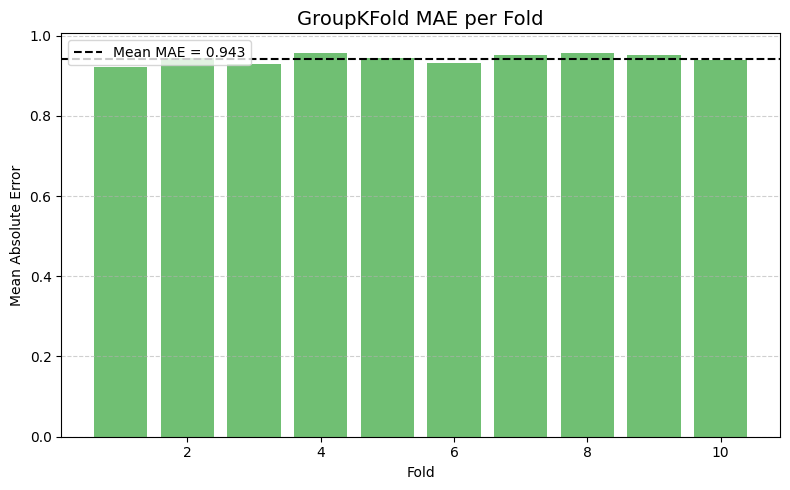

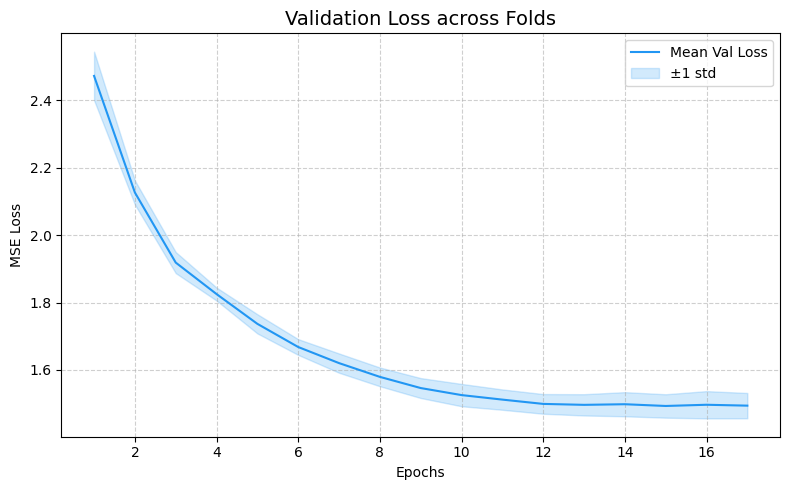

In [31]:
# Calculate groups for full dataset
full_groups = compute_deal_id_series(df)

X_train_set, X_test, y_train_set, y_test, groups_train, groups_test = train_test_split(
    X, y, full_groups, test_size=0.2, random_state=42, stratify=None
)

fold_maes = group_kfold_cv(X_train, y_train, groups_train)

The fact that the validation losses for the folds are very close (low standard deviation) indicates that the dataset is statistically sound

## Grid Search

To find the ideal hyperparameters for the model the Grid Search approach can be used.

The hyperparameters that are subject of the search are:

- number of layers (or blocks as defined earlier)
- number of neurons per layer (as in the dense layer)
- droput percentage
- learning rate

If a grid search returns one of the highest or lowest values provided for a given hyperparameter there is a chance that a even higher or lower value might be better. In this case a new grid search should be executed, using the old best value as the median in a new provided set.

The number of neurons per layer limited to 1024 to limit execution time.

The following is code for the last grid search executed, providing some of the best values found for the hyperparameters and obtaining the final best values.

In [32]:
# --- Define KerasTuner HyperModel wrapper ---
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        """
      Best Hyperparameters:
  n_layers: 2
  n_neurons: 1024
  dropout: 0.2
  lr: 0.0005
  batch_size: 256
  epochs: 100
  """
        # define hyperparameters search space (36 trials)
        n_layers = hp.Choice('n_layers', [1, 2, 3])
        n_neurons = hp.Choice('n_neurons', [512, 1024])
        dropout = hp.Choice('dropout', [0.3, 0.4, 0.5])
        lr = hp.Choice('lr', [5e-4, 1e-4])

        return build_model(
            input_dim=X_train.shape[1],
            n_layers=n_layers,
            n_neurons=n_neurons,
            dropout=dropout,
            lr=lr
        )

    def fit(self, hp, model, *args, **kwargs):
        # define batch size and epochs
        kwargs['batch_size'] = hp.Choice('batch_size', [256])
        kwargs['epochs'] = hp.Choice('epochs', [150])  # no need to search, thanks to early stopping
        return model.fit(*args, **kwargs)


# --- Split your data ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_set, y_train_set, test_size=0.2, random_state=42
)

# --- Initialize the tuner ---
tuner = kt.GridSearch(
    hypermodel=MyHyperModel(),
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=None,  # optional — can limit for faster runs
    seed=42,
    directory="kt_gridsearch",
    project_name="regression_tuning"
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# --- Run the search ---
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

# --- Get the best model and parameters ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
for hyp, value in best_hp.values.items():
    print(f"  {hyp}: {value}")

# --- Evaluate the best model ---
val_loss, val_mae = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest model MAE on validation: {val_mae:.4f}")

Reloading Tuner from kt_gridsearch/regression_tuning/tuner0.json


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Best Hyperparameters:
  n_layers: 2
  n_neurons: 1024
  dropout: 0.5
  lr: 0.0005
  batch_size: 256
  epochs: 150

Best model MAE on validation: 0.8606


## Final Model

After finding the best hyperparameters the final model can be trained on the full training set, to then be evaluated on the test set.

Epoch 1/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 71.4696 - mae: 8.0299 - val_loss: 3.6320 - val_mae: 1.5663
Epoch 2/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 10.3127 - mae: 2.5556 - val_loss: 2.1638 - val_mae: 1.1677
Epoch 3/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 7.1480 - mae: 2.1332 - val_loss: 1.9672 - val_mae: 1.1038
Epoch 4/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 5.5908 - mae: 1.8836 - val_loss: 1.7938 - val_mae: 1.0490
Epoch 5/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 4.6735 - mae: 1.7258 - val_loss: 1.7496 - val_mae: 1.0293
Epoch 6/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 4.0532 - mae: 1.6030 - val_loss: 1.6616 - val_mae: 1.0006
Epoch 7/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 3.5500 - mae: 1.4967 - val_loss: 1.5799 - val_mae: 0.9736
Epoch 8/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 3.1429 - mae: 1.4096 - val_loss: 1.5697 - val_mae: 0.9728
Epoch 9/150
162/162 ━━━━━━━━━━━━━━

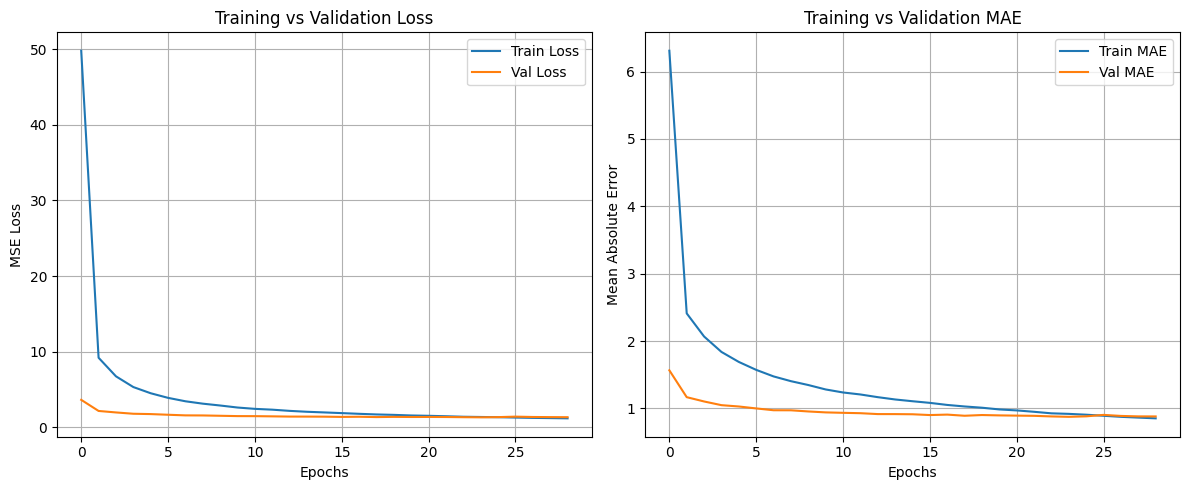

In [34]:
model = build_model(n_layers=2, n_neurons=1024, dropout=0.5, lr=0.0005)
history, model = train_model(model, X_train, y_train, X_val, y_val, batch_size=256, epochs=150)

# Plot training history
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# MAE curve
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

### Evaluation

In [36]:
model.summary()

loss, mae = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}\nTest MAE: {mae:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1024)           │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,665,925 (13.98 MB)

 Trainable params: 1,220,609 (4.66 MB)

 Non-trainable params: 4,096 (16.00 KB)

 Optimizer params: 2,441,220 (9.31 MB)

404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.3252 - mae: 0.8779
Test loss: 1.3088
Test MAE: 0.8743


## Future Work

Many improvements could be considered for this model, each with pros and cons.

### Feature Engineering

Many derived features could be added to the input matrix, mimicking considerations in bridge strategy literature, such as:

- high card value (HCV): sum of points of high value cards in hand (A,K,Q,J)
- Suit Distribution: number of cards per suit, indicating how balanced the hand is

Although by adding these Domain-Informed Features the model is directed to 'think' like a human player, possibly being dissuaded from attempting novel approaches and considerations.

### Data Encoding

The one hot encoding choosen is the simplest way to encode playing cards. A more sofisticated approach may yield a better accuracy, such as:

- Ordinal encoding: rappresent every card with an integer in [1..52]
- Suit-Rank split encoding: rappresent every card with one hot vectors, one for suit and one for rank (17-dim vector per card)

### Dataset Collection

The brigebase database provides games going back to the year 2009, so the dataset dimension could be increased by scraping more data.

Also the dataset shows unbalanced distributions for the trump and trick values. It could be attempted to remove some data to ensure the model is fed balanced data to try and improve edge case accuracy.

### Dataset Generation

Many applications exist that predict the outcome of a game given the starting hands. These could be used to generate a fully automated dataset, but some cons must be considered:

- These data would rappresent the ideal match and may not take into account the human factor of the game
- The number of tricks won would be calculated knowing the hands of all players, a situation that would not occur in normal play. The model also generates it's results without seeing the hands of two out of four players, so it's results may not converge correctly from such a generated dataset

### Model Architecture

The current model has a rather simple fully connected architecture, a more sofisticated architecture could yield an improved accuracy or reduce training time and model parameters, such as:

- Encoder-Decoder: an embedding could be used to map the input space to a lower dimensional latent space

## Conclusions

The model trained obtained a pretty low MAE having a low number of parameters. The MAE obtained is in line with the skill level expected from high level bridge players.

Although a simple model architecture it has proven to be effective in simulating human level competence on a hard task with not much provided information.